<a href="https://colab.research.google.com/github/Reptilefury/coursera-machine-learning/blob/main/Simple_Audio_Recognition_(Recognizing_Key_words).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pathlib
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models 
from IPython import display
import matplotlib.pyplot as plt


In [2]:
#Set the seed value for experiment reproducibility 
seed = 42 
tf.random.set_seed(seed)
np.random.seed(seed)

In [3]:
dataset_path = 'data/mini_speech_commands'
url = "http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip"

data_dir = pathlib.Path(dataset_path)
#Check if the file exists and download the file
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin = url,
      extract = True,cache_dir ='.',cache_subdir='data')



182091776/182082353 [==============================] - 1s 0us/step


The dataset audio clips are stored in eight folders corresponding to each command: no, yes, down, go, left, up, right, stop 

In [4]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:',commands)

Commands: ['right' 'stop' 'yes' 'up' 'down' 'left' 'go' 'no']


Extract audio clips into a list called filenames and shuffle them:

In [5]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)

num_samples = len(filenames)

print('Number of total examples:',num_samples)
print('Number of examples per label:',len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:',filenames[0])


Number of total examples: 8000
Number of examples per label: 1000
Example file tensor: tf.Tensor(b'data/mini_speech_commands/left/62641b88_nohash_0.wav', shape=(), dtype=string)


Split the file names into training validation and test sets repsectively : 80:10:10

In [6]:
train_files = filenames[:6400]
val_files = filenames[6400: 6400 + 800]
test_files = filenames[-800:]

print("Training set files:", len(train_files)) 
print('Validation set files:',len(val_files))
print('Testing set files:', len(test_files))

Training set files: 6400
Validation set files: 800
Testing set files: 800


In [7]:
test_file = tf.io.read_file(dataset_path+'/down/0a9f9af7_nohash_0.wav')
test_audio,_ = tf.audio.decode_wav(contents=test_file)
test_audio.shape

TensorShape([13654, 1])

Function that preprocesses the dataset's raw wav audio

In [8]:
def decode_audio(audio_binary):
  audio,_ = tf.audio.decode_wav(contents=audio_binary)#Returns the audio and sample rate 
  return tf.squeeze(audio,axis=-1)

In [9]:
def get_label(file_path):
  parts = tf.strings.split(
      input= file_path,
      sep = os.path.sep,
  )
  return parts[-2]

In [10]:
from tensorflow.python.ops.gen_audio_ops import decode_wav
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  wavform = decode_audio(audio_binary)
  return  wavform,label

AUTOTUNE = tf.data.AUTOTUNE

file_ds = tf.data.Dataset.from_tensor_slices(train_files)


waveform_ds = file_ds.map(
    map_func = get_waveform_and_label,
    num_parallel_calls=AUTOTUNE
)

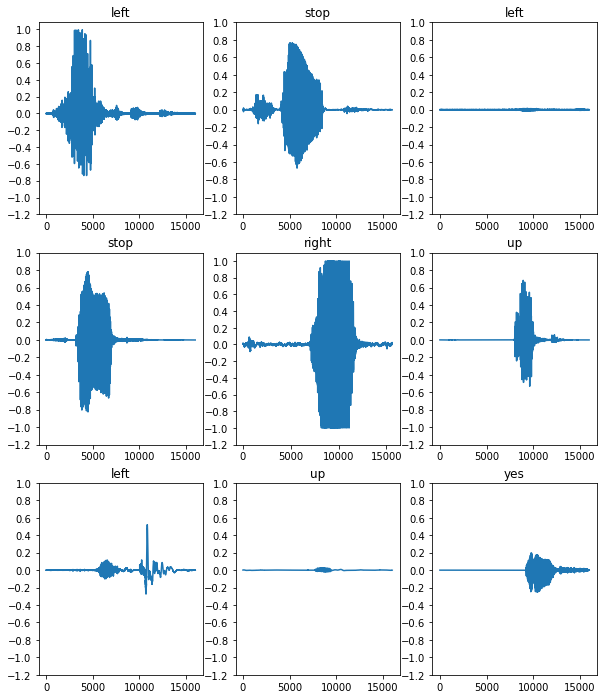

In [11]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

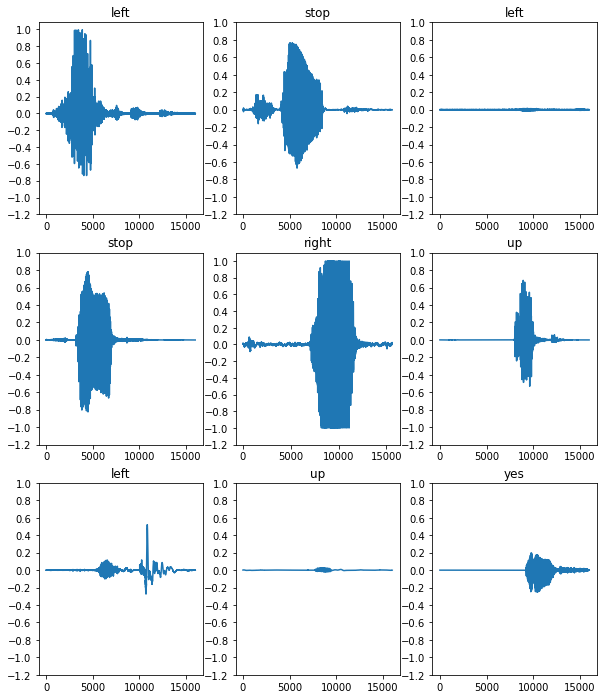

In [12]:
import matplotlib.pyplot as plt

rows = 3
cols = 3
n = rows * cols 
fig, axes = plt.subplots(rows,cols , figsize=(10,12))
for i, (audio,label) in enumerate(waveform_ds.take(n)):
  r = i //cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2,1.2,0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

In [13]:
def get_spectrogram(waveform):
  # Zero-padding for an audio waveform with less than 16,000 samples.
  input_len = 16000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [16000] - tf.shape(waveform),
      dtype=tf.float32)
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Concatenate the waveform with `zero_padding`, which ensures all audio
  # clips are of the same length.
  equal_length = tf.concat([waveform, zero_padding], 0)
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [14]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label',label)
print('Wave form shape:', waveform.shape)
print('spectrogram shape:',spectrogram.shape)
print('Audio playback:')
display.display(display.Audio(waveform,rate=16000))

Label left
Wave form shape: (16000,)
spectrogram shape: (124, 129, 1)
Audio playback:


Function for displaying a spectrogram

In [15]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

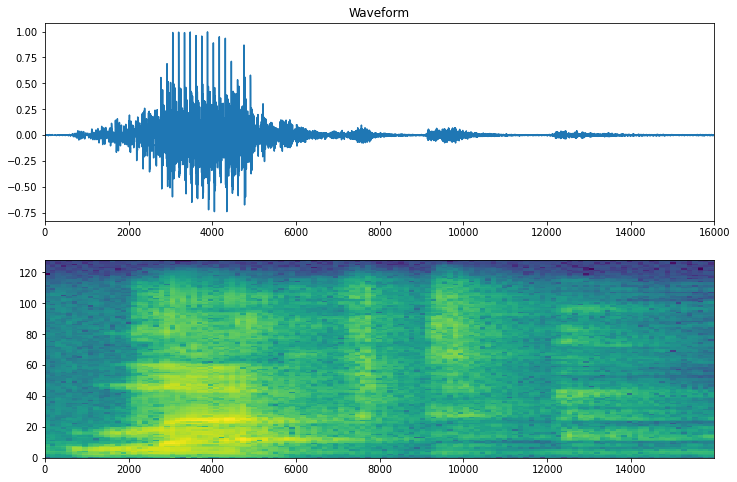

In [16]:
fig,axes = plt.subplots(2, figsize=(12,8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale,waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim(0,16000)

plot_spectrogram(spectrogram.numpy(), axes[1])


Function that transforms wav into spectrograms and their corresponding label ids as their id

In [17]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  label_id = tf.math.argmax(label == commands)
  return spectrogram, label_id

In [18]:
spectrogram_ds = waveform_ds.map(
    map_func = get_spectrogram_and_label_id,
    num_parallel_calls = AUTOTUNE
)

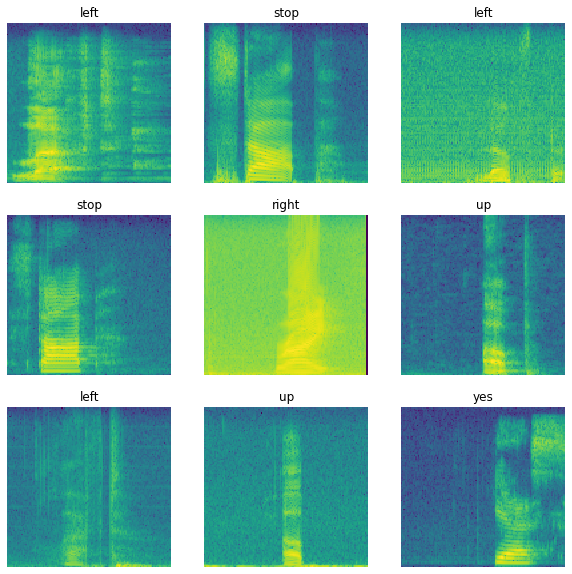

In [19]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

In [20]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(
      map_func=get_waveform_and_label,
      num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)
  return output_ds

In [21]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

Batch the training and validation sets for model training

In [22]:
batch_size = 64 
train_ds = train_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

Add Dataset Cache and Dataset prefetch to reduce latency while training

In [23]:
train_ds = train_ds.cache().prefetch(buffer_size= AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size= AUTOTUNE)

In [24]:
len(train_ds)

100

In [25]:
type(train_ds)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [26]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

Input shape: (124, 129, 1)


In [27]:
model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

#model.summary()


In [28]:
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),optimizer = tf.keras.optimizers.Adam(),metrics=['Accuracy'])

In [30]:
#Train the model 
epochs = 20
history = model.fit(train_ds,epochs=epochs,validation_data=val_ds,verbose=1,callbacks=tf.keras.callbacks.EarlyStopping(verbose=1,patience=5))

Epoch 1/20
100/100 [==============================] - 1s 11ms/step - loss: 0.2036 - Accuracy: 0.9270 - val_loss: 0.5101 - val_Accuracy: 0.8712
Epoch 2/20
100/100 [==============================] - 1s 10ms/step - loss: 0.1826 - Accuracy: 0.9352 - val_loss: 0.5061 - val_Accuracy: 0.8600
Epoch 3/20
100/100 [==============================] - 1s 12ms/step - loss: 0.1875 - Accuracy: 0.9392 - val_loss: 0.4958 - val_Accuracy: 0.8650
Epoch 4/20
100/100 [==============================] - 1s 11ms/step - loss: 0.1764 - Accuracy: 0.9406 - val_loss: 0.4658 - val_Accuracy: 0.8637
Epoch 5/20
100/100 [==============================] - 1s 10ms/step - loss: 0.1762 - Accuracy: 0.9378 - val_loss: 0.5487 - val_Accuracy: 0.8600
Epoch 6/20
100/100 [==============================] - 1s 11ms/step - loss: 0.1607 - Accuracy: 0.9436 - val_loss: 0.5405 - val_Accuracy: 0.8675
Epoch 7/20
100/100 [==============================] - 1s 11ms/step - loss: 0.1713 - Accuracy: 0.9409 - val_loss: 0.4806 - val_Accuracy: 0.8687

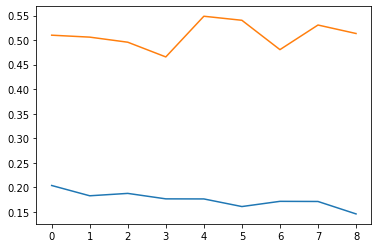

In [33]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'],metrics['val_loss'])


In [58]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels) 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if __name__ == '__main__':


In [62]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

ValueError: ignored

In [43]:
test_acc

array([1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.])

In [45]:
test_audio.shape

(1, 64, 124, 129, 1)